In [ ]:
#using Revise
using DrWatson
@quickactivate "ABoxWorld"
include(srcdir("ABoxWorld.jl"));

In [1]:
using LinearAlgebra
using TensorOperations

using CairoMakie
CairoMakie.activate!()
#using GLMakie
#GLMakie.activate!()

# in ordert to have unblurred pictures
#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300

In [2]:
wirings.nb_columns = 1 #TODO: Might need reconstruction of A, B, C and D tensors in wirings.jl file

1

---
# I. Test a Wiring $\mathsf{W}$ in a Triangle

In [3]:
convert_matrixbox_to_nsjoint = wirings.convert_matrixbox_to_nsjoint
convert_nsjoint_to_matrixbox = wirings.convert_nsjoint_to_matrixbox


MaxMixedBox = wirings.convert_nsjoint_to_matrixbox(nsboxes.reconstructFullJoint(UniformRandomBox((2, 2, 2, 2))))
PR(μ, ν, σ) = wirings.convert_nsjoint_to_matrixbox(nsboxes.reconstructFullJoint(PRBoxesCHSH(;μ=μ, ν=ν, σ=σ)))
CanonicalPR = PR(0, 0, 0)
PL(α, γ, β, λ) = wirings.convert_nsjoint_to_matrixbox(nsboxes.reconstructFullJoint(LocalDeterministicBoxesCHSH(;α=α, γ=γ, β=β, λ=λ)))
SR = (PL(0,0,0,0) .+ PL(0,1,0,1)) ./ 2

W_BS09 = [0., 0., 1., 1.,              # f_1(x, a_2) = x
            0., 0., 1., 1.,              # g_1(y, b_2) = y
            0., 0., 0., 1.,              # f_2(x, a_1) = a_1*x
            0., 0., 0., 1.,              # g_2(y, b_1) = b_1*y
            0., 1., 1., 0., 0., 1., 1., 0.,  # f_3(x, a_1, a_2) = a_1 + a_2 mod 2
            0., 1., 1., 0., 0., 1., 1., 0.   # g_3(y, b_1, b_2) = b_1 + b_2 mod 2
            ]




32-element Vector{Float64}:
 0.0
 0.0
 1.0
 1.0
 0.0
 0.0
 1.0
 1.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 1.0
 1.0
 0.0
 0.0
 1.0
 1.0
 0.0

In [4]:
BoxProduct = wirings.tensorized_boxproduct
reduc_BoxProduct = wirings.reduc_tensorized_boxproduct

IC_Bound = Original_IC_Bound()
IC_Bound_LHS(P::Array{Float64, 4}) = conditions.evaluate(IC_Bound, P)


IC_Bound_LHS(convert_matrixbox_to_nsjoint(MaxMixedBox))

0.0

In [5]:


function proportion_blue_points_in_a_segment(W::Matrix{<:Real}, Box1::Matrix{Float64}, Box3::Matrix{Float64}, box_grid_size::Int, max_box_power::Int, threshold::Real)
    
    number_blue_points = 0

    for i in 0:box_grid_size+1-1
        α = i/box_grid_size
        P = (α .* Box1) .+ ((1-α) .* Box3)   # P is a 4x4 matrix
        color_point = :orangered

        Qright=convert_matrixbox_to_nsjoint(deepcopy(P))  # Q is a 2x2x2x2 tensor
        Qcenter=convert_matrixbox_to_nsjoint(deepcopy(P))  # Q is a 2x2x2x2 tensor
        Qleft=convert_matrixbox_to_nsjoint(deepcopy(P))  # Q is a 2x2x2x2 tensor
        value = max(IC_Bound_LHS(Qright), IC_Bound_LHS(Qcenter), IC_Bound_LHS(Qleft))
        if value > threshold
            color_point = RGBf(0, 0.1, 0.1)
            number_blue_points += 1
        else
            if value != IC_Bound.setBounds[:Q] #0.75 TODO: Probably this should be something else!
                for l in 0:max_box_power-1
                    color_point != :orangered ? break : nothing
                    Qright=reduc_BoxProduct(W, convert_nsjoint_to_matrixbox(Qright), P)
                    Qcenter=reduc_BoxProduct(W, convert_nsjoint_to_matrixbox(Qcenter), convert_nsjoint_to_matrixbox(Qcenter))
                    Qleft=reduc_BoxProduct(W, P, convert_nsjoint_to_matrixbox(Qleft))
                    value = max(IC_Bound_LHS(Qright), IC_Bound_LHS(Qcenter), IC_Bound_LHS(Qleft))
                    if value > threshold
                        color_point = RGBf(0, 0.1*(1-l/max_box_power)+1*(l/max_box_power), 0.1*(1-l/max_box_power)+1*(l/max_box_power))
                        number_blue_points += 1
                    end
                end
            end
        end
    end
    ^#@show number_blue_points / box_grid_size
    return number_blue_points / box_grid_size
end

proportion_blue_points_in_a_segment (generic function with 1 method)

In [11]:
function test_wiring_triangle(;W::Vector{<:Real}, Box1::Pair{String, Matrix{Float64}}, Box2::Pair{String, Matrix{Float64}}, Box3::Pair{String, Matrix{Float64}}, box_grid_size::Int, max_box_power::Int, threshold::Real, verbose::Bool=false, good_proportion::Float64=0.39)

    # W is a vector of size 32
    n = wirings.nb_columns
    W = repeat(W, 1, n)
    # Now W is a 32xn tensor

    # Check the proportion of blue points in the top segment -> stop if there is no enough blue points.
    if proportion_blue_points_in_a_segment(W, Box1.second, Box3.second, box_grid_size, 21, threshold) < good_proportion
        verbose ? print("-- Not violating IC:  ", Box1.first," -- ", Box3.first) : nothing
        return ""
    end

    #Prepare the figure:
    fig = Figure(; size=(600,400))
    ax = Axis(fig[1, 1]; )
    
    #Start drawing:
    X = [1 3; 4 1; 4 5]
    #triangle = Polygon(Point2f[X[1,:], X[2,:], X[3,:]])
    poly!(ax, Point2f[X[1,:], X[2,:], X[3,:]], color = :snow) ##(1.0, 0.9803921568627451, 0.9803921568627451); https://juliagraphics.github.io/Colors.jl/stable/namedcolors/

    for i in 0:box_grid_size+1-1
        for j in 0:box_grid_size-i+1-1
            α, β = i/box_grid_size, j/box_grid_size
            P = (α * Box1.second) .+ (β * Box2.second) .+ ((1-α-β)*Box3.second)   # P is a 4x4 matrix
                
            color_point = :orangered

            # Look at all possible ways to multiply P with itself via W:
            Qright=convert_matrixbox_to_nsjoint(deepcopy(P))  # Q is a 2x2x2x2 tensor
            Qcenter=convert_matrixbox_to_nsjoint(deepcopy(P))  # Q is a 2x2x2x2 tensor
            Qleft=convert_matrixbox_to_nsjoint(deepcopy(P))  # Q is a 2x2x2x2 tensor
            value = max(IC_Bound_LHS(Qright), IC_Bound_LHS(Qcenter), IC_Bound_LHS(Qleft))
            if value > threshold
                color_point = RGBf(0, 0.1, 0.1)
            else
                for l in 0:max_box_power-1
                    color_point != :orangered ? break : nothing
                    Qright=reduc_BoxProduct(W, convert_nsjoint_to_matrixbox(Qright), P)
                    Qcenter=reduc_BoxProduct(W, convert_nsjoint_to_matrixbox(Qcenter), convert_nsjoint_to_matrixbox(Qcenter))
                    Qleft=reduc_BoxProduct(W, P, convert_nsjoint_to_matrixbox(Qleft))
                    value = max(IC_Bound_LHS(Qright), IC_Bound_LHS(Qcenter), IC_Bound_LHS(Qleft))
                    
                    try 
                        nsboxes.NSBox((2,2,2,2), Qright)
                        nsboxes.NSBox((2,2,2,2), Qcenter)
                        nsboxes.NSBox((2,2,2,2), Qleft)
                    catch e
                        @warn "Failed NSBox creation at level $l. Probably numerical imprecision, so you'll want to reduce max_box_power! ( $e )"
                    end
                    #if value > 8.001  ### Found problems for high max_box_power values -> Probably numerical imprecision = instability! (Miniscule NS conditions deviation O(10^-8) but exploding "value" O(10^1)!)
                    #    @warn "At level $l, value is greater than algebraic max: $value"
                    #    value == IC_Bound_LHS(Qright) && (@show nsboxes.NSBox((2,2,2,2), Qright))
                    #    value == IC_Bound_LHS(Qcenter) && (@show nsboxes.NSBox((2,2,2,2), Qcenter))
                    #    value == IC_Bound_LHS(Qleft) && (@show nsboxes.NSBox((2,2,2,2), Qleft))
                    #end
                    if value > threshold && value < 8.001 #Algebraic maximum for bound.
                        color_point = RGBf(0, 0.1*(1-l/max_box_power)+1*(l/max_box_power), 0.1*(1-l/max_box_power)+1*(l/max_box_power))
                    end
                end
            end
            scatter!(ax, [X[1,1]*α + X[2,1]*β + X[3,1]*(1-α-β)], [X[1,2]*α + X[2,2]*β + X[3,2]*(1-α-β)]; color = color_point, marker=:circle, markersize=12)
        end
    end 
    
    text!(ax, Box1.first, position=(X[1,1], X[1,2]+0.1), space = :data, align = (:center, :baseline))
    text!(ax, Box2.first, position=(X[2,1]+0.1, X[2,2]), space = :data, align = (:center, :center))
    text!(ax, Box3.first, position=(X[3,1]+0.1, X[3,2]), space = :data, align = (:center, :center))
    

    axislegend(ax, [[MarkerElement(color =RGBf(0, 0.1, 0.1), marker=:circle, markersize = 15, points = Point2f[(0.2, 0.5)]), MarkerElement(color =RGBf(0, 0.7/2, 0.7/2), marker=:circle, markersize = 15, points = Point2f[(0.8, 0.5)]), MarkerElement(color =RGBf(0, 0.7, 0.7), marker=:circle, markersize = 15, points = Point2f[(1.4, 0.5)])], 
                    MarkerElement(color =:orangered, marker=:circle, markersize = 15)],
                    ["      IC-violating boxes (unwired, $(Int(floor(max_box_power/2))), $max_box_power)","     Inconclusive"];
                    position = :lt, labelsize = 10 )
    
    fig
end

test_wiring_triangle (generic function with 1 method)

### Let's go:

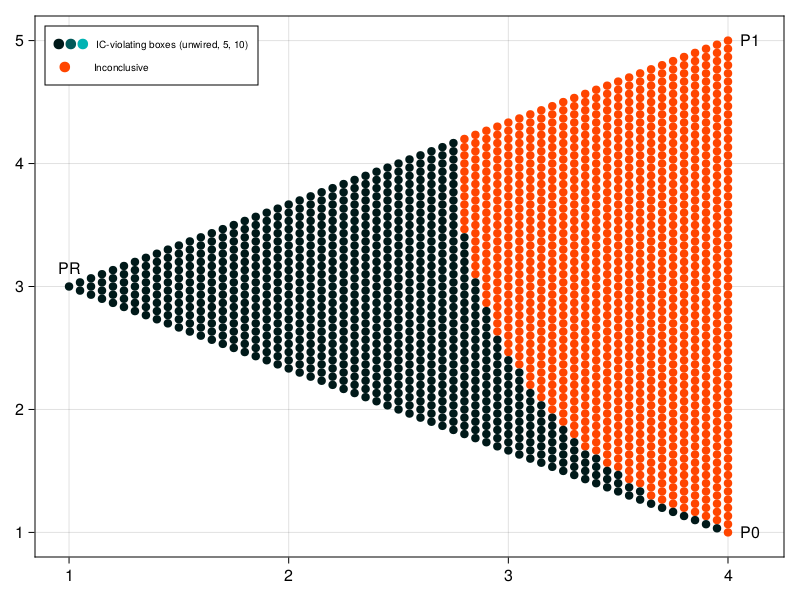

In [17]:
testW = W_BS09

#Extremal wire types & parameters (binary):
Dict(:D => [:α,], 
    :O => [:α, :β, :γ], 
    :X => [:α, :β, :γ],
    :A => [:α, :β, :γ, :δ, :ε],
    :S => [:α, :β, :γ, :δ, :ε],
    )


#testW = extremal_wires(:A, Dict(:α=>0, :β=>0, :γ=>0, :δ=>0, :ε=>0), 
#                        :X, Dict(:α=>1, :β=>1, :γ=>1),
#                        )

test_wiring_triangle(;
    W = testW,
    Box1= "PR"=>CanonicalPR,
    Box2= "P0"=>PL(0, 0, 0, 0),
    Box3= "P1"=>(CanonicalPR .+ MaxMixedBox) ./2, #PL(1, 0, 1, 0),
    box_grid_size = 60,  # 60
    max_box_power = 10,  # 10
    threshold = IC_Bound.setBounds[:Q],
    verbose = true,
    good_proportion = 0.39
)

--- 
# II. Test a wiring $\mathsf{W}$ in many Triangles

In [8]:
boxes_to_be_tested = [ (0,0,0,0), (0,0,0,1), (0,0,1,0), (0,0,1,1), (0,1,0,0),
                        (0,1,0,1), (0,1,1,0), (0,1,1,1), (1,0,0,0), (1,0,0,1),
                        (1,0,1,0), (1,0,1,1), (1,1,0,0), (1,1,0,1),  (1,1,1,0),
                         ] #(1,1,1,1) != satisfying NS condition; needs debug.

function test_wiring_in_mulitple_triangles(;W::Vector{<:Real}, fixed_box::Pair{String, Matrix{Float64}}, known_collapsing_W::Vector{Any}, verbose::Bool=false, compare_with_known_wirings::Bool=true, box_grid_size::Int=60, max_box_power::Int=20)
    # W_list is given as a list here

    wirings.nb_columns != 1 && (@warn " Please, set the number of columns to 1 (i.e. wirings.nb_columns).")

    W = float.(W)
    verbose && println("------ Number of known wirings: ", length(known_collapsing_W))

    println("W = ",W)
    if compare_with_known_wirings
        for i in 1:length(known_collapsing_W)
            if all(W .== known_collapsing_W[i])
                println(" !!!  This wiring is already known: ",i,"th/ ",length(known_collapsing_W),"  !!!")
                return nothing
            end
        end
    end
    
    threshold = IC_Bound.setBounds[:Q]

    p = proportion_blue_points_in_a_segment(repeat(W, 1, 1), CanonicalPR, fixed_box.second, 40, 40, threshold)
    out_str = ""
    verbose && (out_str ="------ ")
    println(out_str)
    println("Proportion of blue points in the segment PR -- ", fixed_box.first, ":   ", 100*p, " %")

    if p>0.4
        #boxes_to_be_tested = non_local_boxes.utils.boxes_to_be_tested
        for box_number in boxes_to_be_tested
            bp1, bp2, bp3, bp4 = box_number
            if !all(PL(bp1, bp2, bp3, bp4) .== fixed_box.second)
                test_wiring_triangle(
                    W = W,
                    Box1 = "PR" => CanonicalPR,
                    Box2 = fixed_box,
                    Box3 = "PL($(bp1), $(bp2), $(bp3), $(bp4))" => PL(bp1, bp2, bp3, bp4),
                    box_grid_size = box_grid_size,
                    max_box_power = max_box_power,
                    threshold = threshold,
                    verbose = false
                )
            end
        end
    end
    verbose && print("---------- FINISHED ----------")
end

test_wiring_in_mulitple_triangles (generic function with 1 method)

### Let's go:

In [9]:

W = [0.,0.,1.,0.,1.,0.,0.,1.,0.,0.,1.,1.,1.,1.,0.,0.,1.,0.,0.,1.,0.,1.,1.,0.,1.,0.,0.,1.,1.,0.,0.,1.]

wirings.print_functions_from_wires(W)
println("")

test_wiring_in_mulitple_triangles(; W=W,
                                    #fixed_box= "PL(1,0,0,0)" => PL(0,0,0,0),
                                    fixed_box= "PR+I / 2" => (CanonicalPR .+ MaxMixedBox) ./ 2,
                                    known_collapsing_W = [],
                                    verbose=true,
                                    compare_with_known_wirings=true,
                                    box_grid_size=60, 
                                    max_box_power=10
                                )

f_1(x,a2) = x ⊕ -1.0 x·a2
g_1(y,b2) = -1.0 y ⊕ -1.0 b2 ⊕ 1.0 
f_2(x,a1) = x
g_2(y,b1) = -1.0 y ⊕ 1.0 
f_3(x,a1,a2) = -1.0 x ⊕ -1.0 a1 ⊕ -1.0 a2 ⊕ 1.0 
g_3(y,b1,b2) = -1.0 b1 ⊕ -1.0 b2 ⊕ 1.0 



------ Number of known wirings: 0
W = 

[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0]


------ 
Proportion of blue points in the segment PR -- PR+I / 2:   60.0 %

┌ Warning: Failed NSBox creation at level 1. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 2. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 3. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 4. Probably numerical 

┌ Warning: Failed NSBox creation at level 4. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 5. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 6. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 7. Probably numerical 

┌ Warning: Failed NSBox creation at level 7. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 8. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 9. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 0. Probably numerical 

┌ Warning: Failed NSBox creation at level 2. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 3. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 4. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 5. Probably numerical 

┌ Warning: Failed NSBox creation at level 5. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 6. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 7. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 8. Probably numerical 

┌ Warning: Failed NSBox creation at level 8. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 9. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 0. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 1. Probably numerical 

┌ Warning: Failed NSBox creation at level 4. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 5. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 6. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 7. Probably numerical 

┌ Warning: Failed NSBox creation at level 7. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 8. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 9. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 0. Probably numerical 

┌ Warning: Failed NSBox creation at level 1. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 2. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 3. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 4. Probably numerical 

┌ Warning: Failed NSBox creation at level 0. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 1. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 2. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 3. Probably numerical 

┌ Warning: Failed NSBox creation at level 3. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 4. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 5. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 6. Probably numerical 

┌ Warning: Failed NSBox creation at level 6. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 7. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 8. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 9. Probably numerical 

┌ Warning: Failed NSBox creation at level 8. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 9. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 0. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 1. Probably numerical 

┌ Warning: Failed NSBox creation at level 2. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 3. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 4. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 5. Probably numerical 

┌ Warning: Failed NSBox creation at level 6. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 7. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 8. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 9. Probably numerical 

┌ Warning: Failed NSBox creation at level 9. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50


┌ Warning: Failed NSBox creation at level 0. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 1. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 2. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 3. Probably numerical 

┌ Warning: Failed NSBox creation at level 3. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 4. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 5. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 6. Probably numerical 

┌ Warning: Failed NSBox creation at level 6. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 7. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 8. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 9. Probably numerical 

┌ Warning: Failed NSBox creation at level 8. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 9. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 0. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 1. Probably numerical 

┌ Warning: Failed NSBox creation at level 1. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 2. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 3. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 4. Probably numerical 

┌ Warning: Failed NSBox creation at level 4. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 5. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 6. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 7. Probably numerical 

┌ Warning: Failed NSBox creation at level 6. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 7. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 8. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 9. Probably numerical 

┌ Warning: Failed NSBox creation at level 9. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 0. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 1. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 2. Probably numerical 

┌ Warning: Failed NSBox creation at level 2. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 3. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 4. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 5. Probably numerical 

┌ Warning: Failed NSBox creation at level 9. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 0. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 1. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 2. Probably numerical 

┌ Warning: Failed NSBox creation at level 3. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 4. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 5. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 6. Probably numerical 

┌ Warning: Failed NSBox creation at level 6. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 7. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 8. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 9. Probably numerical 

┌ Warning: Failed NSBox creation at level 2. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 3. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 4. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 5. Probably numerical 

┌ Warning: Failed NSBox creation at level 6. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 7. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 8. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 9. Probably numerical 

┌ Warning: Failed NSBox creation at level 9. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 0. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 1. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 2. Probably numerical 

┌ Warning: Failed NSBox creation at level 9. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 0. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 1. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 2. Probably numerical 

┌ Warning: Failed NSBox creation at level 2. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 3. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 4. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 5. Probably numerical 

┌ Warning: Failed NSBox creation at level 5. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 6. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 7. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 8. Probably numerical 

┌ Warning: Failed NSBox creation at level 1. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 2. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 3. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 4. Probably numerical 

┌ Warning: Failed NSBox creation at level 4. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 5. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 6. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 7. Probably numerical 

┌ Warning: Failed NSBox creation at level 7. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 8. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 9. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 0. Probably numerical 

┌ Warning: Failed NSBox creation at level 2. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 3. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 4. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 5. Probably numerical 

┌ Warning: Failed NSBox creation at level 5. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 6. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 7. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 8. Probably numerical 

┌ Warning: Failed NSBox creation at level 8. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 9. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 0. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 1. Probably numerical 

┌ Warning: Failed NSBox creation at level 3. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 4. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 5. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 6. Probably numerical 

┌ Warning: Failed NSBox creation at level 6. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 7. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 8. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 9. Probably numerical 

┌ Warning: Failed NSBox creation at level 9. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 0. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 1. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 2. Probably numerical 

┌ Warning: Failed NSBox creation at level 4. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 5. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 6. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 7. Probably numerical 

┌ Warning: Failed NSBox creation at level 7. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 8. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 9. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 0. Probably numerical 

┌ Warning: Failed NSBox creation at level 0. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 1. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 2. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 3. Probably numerical 

┌ Warning: Failed NSBox creation at level 5. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 6. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 7. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 8. Probably numerical 

┌ Warning: Failed NSBox creation at level 8. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 9. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 0. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 1. Probably numerical 

┌ Warning: Failed NSBox creation at level 1. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 2. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 3. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 4. Probably numerical 

┌ Warning: Failed NSBox creation at level 9. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 0. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 1. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 2. Probably numerical 

┌ Warning: Failed NSBox creation at level 2. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 3. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 4. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 5. Probably numerical 

┌ Warning: Failed NSBox creation at level 5. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 6. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 7. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 8. Probably numerical 

┌ Warning: Failed NSBox creation at level 1. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 2. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 3. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 4. Probably numerical 

┌ Warning: Failed NSBox creation at level 5. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 6. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 7. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 8. Probably numerical 

┌ Warning: Failed NSBox creation at level 9. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 0. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 1. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 2. Probably numerical 

┌ Warning: Failed NSBox creation at level 2. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 3. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 4. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 5. Probably numerical 

┌ Warning: Failed NSBox creation at level 5. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 6. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 7. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 8. Probably numerical 

┌ Warning: Failed NSBox creation at level 3. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 4. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 5. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 6. Probably numerical 

Excessive output truncated after 524412 bytes.

┌ Warning: Failed NSBox creation at level 6. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 7. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 8. Probably numerical imprecision, so you'll want to reduce max_box_power! ( AssertionError("all(abs.(full_B_marginals .- full_B_marginals[:, :, 1:1, :]) .< global_eps_tol)") )
└ @ Main s:\Sync\University\2023_MRP_2\MRP2_WorkDir\ABoxWorld\Test_if_W_violates_IC.ipynb:50
┌ Warning: Failed NSBox creation at level 9. Probably numerical 